## Meduza.io processing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.cross_validation
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

Сначала скачаем данные в pandas dataframe:

In [2]:
df = pd.read_json('database.json').T
df = df.join(pd.DataFrame(df.social.to_dict()).T)
df.pub_date = pd.DatetimeIndex(df.pub_date)
df['trust']=df.source.apply(lambda x: x.get('trust', None) if type(x) == dict else None)

Разберемся с тем, что мы в итоге получили, с чем можем работать

In [3]:
print df.columns

Index([        u'affiliate',           u'authors',          u'bg_image',
          u'chapters_count',              u'chat',     u'document_type',
           u'document_urls',              u'full',        u'full_width',
                u'fun_type',       u'hide_header',             u'image',
                u'keywords',        u'layout_url',           u'live_on',
                  u'locale',       u'modified_at',       u'one_picture',
                   u'prefs',          u'pub_date',      u'published_at',
                  u'pushed',      u'second_title',     u'share_message',
                  u'social',            u'source',         u'sponsored',
          u'sponsored_card', u'table_of_contents',               u'tag',
                  u'thesis',             u'title',             u'topic',
              u'updated_at',               u'url',           u'version',
          u'vk_share_image',       u'webview_url',      u'with_banners',
                      u'fb',                u'tw', 

Построим boxplot

,fb,tw,vk
count,22558.000000,22558.0,22558.000000
mean,227.275556,0.0,173.536306
std,878.837464,0.0,457.518281
min,0.000000,0.0,0.000000
25%,4.000000,0.0,2.000000
50%,24.000000,0.0,17.000000
75%,126.750000,0.0,196.000000
max,27097.000000,0.0,18636.000000


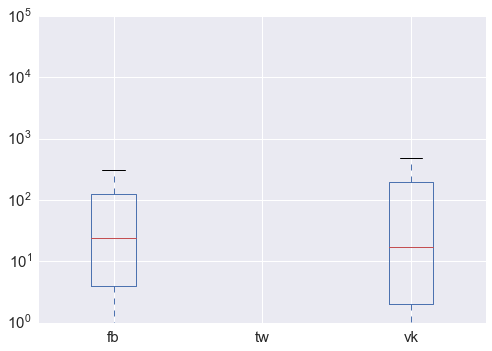

In [4]:
df[['fb', 'tw','vk']].plot.box(logy = True);
df[['fb', 'tw','vk']].describe()

Сразу несколько выводов:
1. Twitter отключил возможность смотреть количество твитнувших новость. :-( Придется обойтись без него
2. Распределение, как и ожидалось, крайне ненормально: есть очень сильные выбросы, которые заметны даже на лог-шкале (сотни тысяч репостов).
3. При этом, среднее число репостов оказалось довольно близким: медиана 24 и 17 (здесь и далее, facebook и вконтакте, соответственно), распределение vk несколько более "размазано".

Так кто же те самые супер-репостнутые новости медузы? Угадаете?

In [5]:
df.sort_values('fb', ascending = False, inplace = False)[['title', 'fb', 'vk']].reset_index().head(10)

,index,title,fb,vk
0,news/2015/01/30/irina-yarovaya-ob-yavila-izuch...,Ирина Яровая объявила изучение иностранных язы...,27097,12439
1,quiz/sovetskaya-gazeta-ili-rossiyskaya,Советская газета или российская?,23159,1344
2,shapito/2016/03/10/glava-lipetskoy-oblasti-vyd...,Глава Липецкой области выдал безумную поздрави...,22286,1289
3,shapito/2016/01/23/ochered-na-serova-kak-otdel...,Очередь на Серова как отдельная страна: как мо...,21687,1324
4,feature/2015/07/03/derzkih-planov-mnogo-malo-v...,«Дерзких планов много. Мало времени»,19990,2952
5,feature/2015/01/30/strana-bolna-esli-shpionov-...,"«Страна больна, если шпионов ищут среди кухаро...",19269,3491
6,quiz/tsvetaeva-ili-guf,Цветаева или Гуф?,18947,9246
7,shapito/2015/12/09/zaderzhki-turetskoy-tkani-p...,Автор антитурецких футболок пожаловался на мон...,18605,6072
8,feature/2014/12/19/vranie-stalo-sutyu-gosudarstva,«Вранье стало сутью государства»,17856,4856
9,feature/2015/09/30/ty-ryadom-s-kotletkoy-po-zn...,«Ты рядом с котлеткой по значимости и не мечта...,16765,3605


In [6]:
df.sort_values('vk', ascending = False, inplace = False)[['title', 'fb', 'vk']].reset_index().head(10)

,index,title,fb,vk
0,news/2015/03/04/gruppa-5-nizza-vossoedinilas-d...,Группа 5’nizza воссоединилась для концертов в ...,3634,18636
1,news/2015/01/30/irina-yarovaya-ob-yavila-izuch...,Ирина Яровая объявила изучение иностранных язы...,27097,12439
2,feature/2014/12/12/moya-orientatsiya-eto-amoralno,«Моя ориентация — это аморально?»,5876,11377
3,live/2014/12/30/prigovor-bratyam-navalnym-onlayn,День приговора Навальному: онлайн,448,11150
4,feature/2015/05/24/pogaday-na-brodskom,Погадай на Бродском,8560,10334
5,news/2015/02/28/v-moskve-ubit-boris-nemtsov,В Москве убит Борис Немцов,16369,10143
6,news/2015/01/14/studentam-vshe-prochitali-lekt...,Студентам ВШЭ прочитали лекции о заряженной во...,5325,9955
7,shapito/2014/12/09/peterburzhskiy-razrabotchik...,Петербургский разработчик создал язык программ...,807,9862
8,quiz/tsvetaeva-ili-guf,Цветаева или Гуф?,18947,9246
9,shapito/2016/01/09/v-yaponii-zheleznaya-doroga...,В Японии железная дорога работает ради одной ш...,7932,8409


Единственное, в чем схожи предпочтения двух соц.сетей: это Ирина Яровая, да, Цветаева с Гуфом.Ъ

Теперь, хочется посмотреть на scatter plot двух величин: ожидается, что данные будут хорошо корелировать друг с другом

In [7]:
df['logvk'] = np.log10(df.vk)
df['logfb'] = np.log10(df.fb)


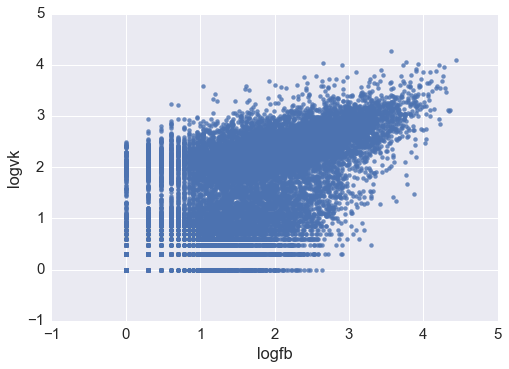

In [8]:
sns.regplot('logfb', 'logvk', data = df )

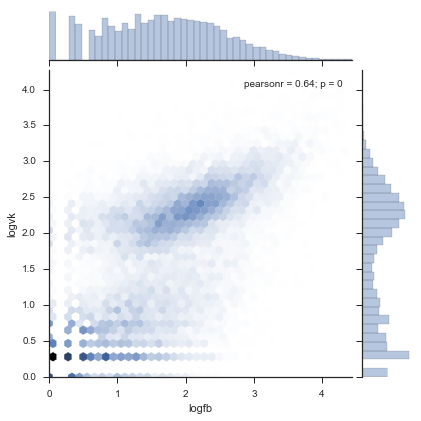

In [9]:
sns.set(style="ticks")
sns.jointplot('logfb', 'logvk', 
              data = df.replace([np.inf, -np.inf], np.nan).dropna(subset = ['logfb', 'logvk']),
              kind="hex")

Кажется, видно два кластера: один с центром в (2.3, 2.4), и второй размазанный около нуля. В целом нет цели провести анализ даже для низкочастотных новостей (тех, которые оказались неинтересными в соц.сетях), так что давайте ограничимся только записями с более 10 лайков в обеих сетях. Не забудем проверить, что мы избавились от незначительного числа наблюдений.

In [10]:
stripped = df[(df.logfb > 1) & (df.logvk > 1)]

In [11]:
print "Working with {0:.0%} of news, {1:.0%} of social network activity".format(
    float(len(stripped)) / len(df), float(stripped[['vk', 'fb']].sum().sum()) / df[['vk', 'fb']].sum().sum()
)

Working with 47% of news, 95% of social network activity


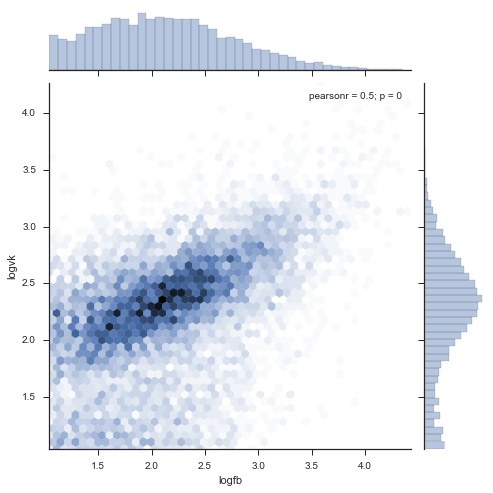

In [12]:
sns.jointplot('logfb', 'logvk', data = stripped, size=7, kind="hex")

# Плотность:

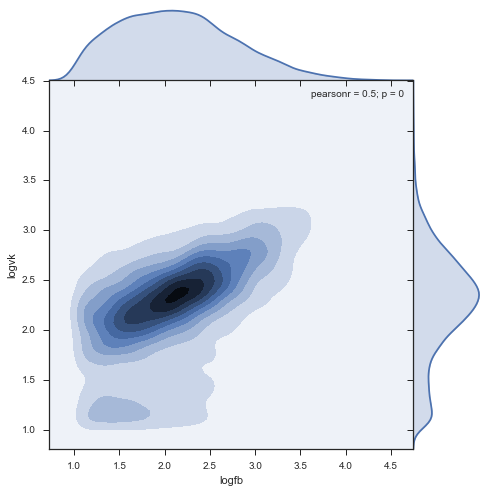

In [13]:
sns.jointplot('logfb', 'logvk', data = stripped, kind="kde", size=7, space=0)

# Выводы:
* Нашли плотный кластер соотношения комментирования: 220 в facebook, 240 во вконтакте.
* Кластер вытянут больше в facebook: в этой соц.сети люди репостят более диапазонно, по сравнению с ВК, где пик достаточно "узкий"
* Есть мини-кластер фейсбучной активности в 150 fb и около 70 vk, достаточно необычный

Теперь хочется посмотреть на это соотношений в динамике: возможно, оно менялось

In [14]:
by_month = stripped.set_index('pub_date').groupby(pd.TimeGrouper(freq = 'MS')).agg({'fb':sum, 'vk':sum})

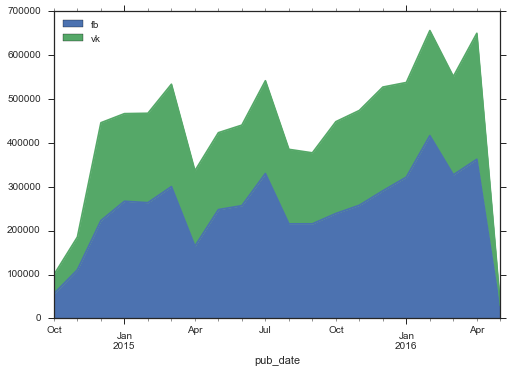

In [15]:
by_month.plot( kind = 'area')

Интересно, что при общем росте объема активности в соц.сетях, фейсбук растёт быстрее

In [ ]:
for month, data in stripped.set_index('pub_date').groupby(pd.TimeGrouper(freq = 'MS')):
    plt.subplots_adjust(top=0.9)
    sns_plot =sns.jointplot('logfb', 'logvk', data = data, kind="kde", size=7, space=0,
                           xlim=(0.5,4), ylim = (0.5,4))
    plt.gcf().suptitle("".join([' ']*40) + month.strftime('%Y-%m'), fontsize=25) # can also get the figure from plt.gcf()
    sns_plot.savefig('dynamics gif/'+month.strftime('%Y-%m')+".png")


In [17]:
from IPython.display import Image
Image(url='dynamics gif/output_dEKwGx.gif')


Довольно занятно, что второй кластер уменьшается со временем, и скорее является артефактом прошлого

In [69]:
sample = pd.concat((stripped[stripped.document_type == document_type].sample(n = 1, replace=True ) 
                    for document_type in stripped.document_type.unique()))

In [70]:
sample

,affiliate,authors,bg_image,chapters_count,chat,document_type,document_urls,full,full_width,fun_type,...,version,vk_share_image,webview_url,with_banners,fb,tw,vk,trust,logvk,logfb
cards/kak-vybrat-horoshiy-velosiped,NaN,[],NaN,16,NaN,card,NaN,False,False,NaN,...,10,NaN,NaN,True,464,0,482,NaN,2.683047,2.666518
feature/2015/02/28/kommentariy-ochen-prostoy-ublyudki,NaN,[],NaN,NaN,NaN,feature,NaN,False,NaN,NaN,...,2,NaN,NaN,True,2050,0,3095,NaN,3.490661,3.311754
shapito/2015/11/20/televeduschiy-dzhimmi-fellon-pozhal-ruku-dzhastinu-biberu,NaN,[],NaN,NaN,NaN,fun,NaN,False,False,video,...,4,/image/share_images/18253_vk.png?1448036195,NaN,True,28,0,186,NaN,2.269513,1.447158
galleries/2015/02/10/mesto-nevynosimyh-stradaniy,NaN,NaN,NaN,NaN,NaN,gallery,NaN,False,False,NaN,...,4,NaN,NaN,False,1217,0,1222,NaN,3.087071,3.085291
live/2015/10/21/manchester-yunayted-v-moskve,NaN,NaN,NaN,NaN,NaN,live,NaN,False,False,NaN,...,6,NaN,NaN,False,20,0,67,NaN,1.826075,1.301030
news/2015/12/24/putin-obvinil-spekulyantov-v-padenii-urovnya-zhizni-rossiyan,NaN,[],NaN,NaN,NaN,news,NaN,False,False,NaN,...,2,NaN,NaN,True,4237,0,1470,3.0,3.167317,3.627058


In [ ]:
sample = pd.concat((stripped[stripped.document_type == document_type].sample(n = 200, replace=True ) 
                    for document_type in stripped.document_type.unique()))

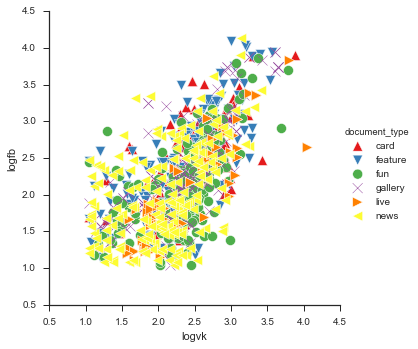

In [44]:
g = sns.FacetGrid(sample, hue="document_type", palette="Set1", size=5,  
                  hue_kws={"marker": ["^", "v", "o", 'x','>','<']})
g.map(plt.scatter, "logvk", "logfb", s=100, linewidth=.5, edgecolor="white")
g.add_legend();


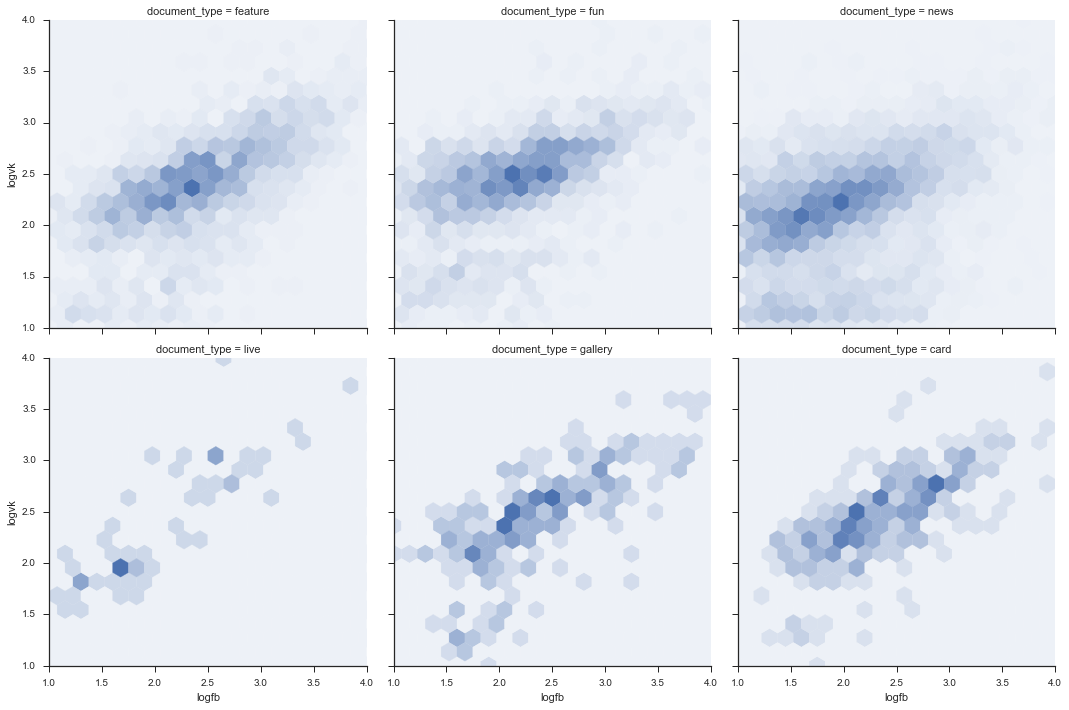

In [67]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=20, cmap=cmap, **kwargs)

g = sns.FacetGrid(stripped.loc[::-1], col="document_type", margin_titles=True, size=5, col_wrap = 3)
g.map(hexbin, "logfb", "logvk", extent=[1, 4, 1, 4]);


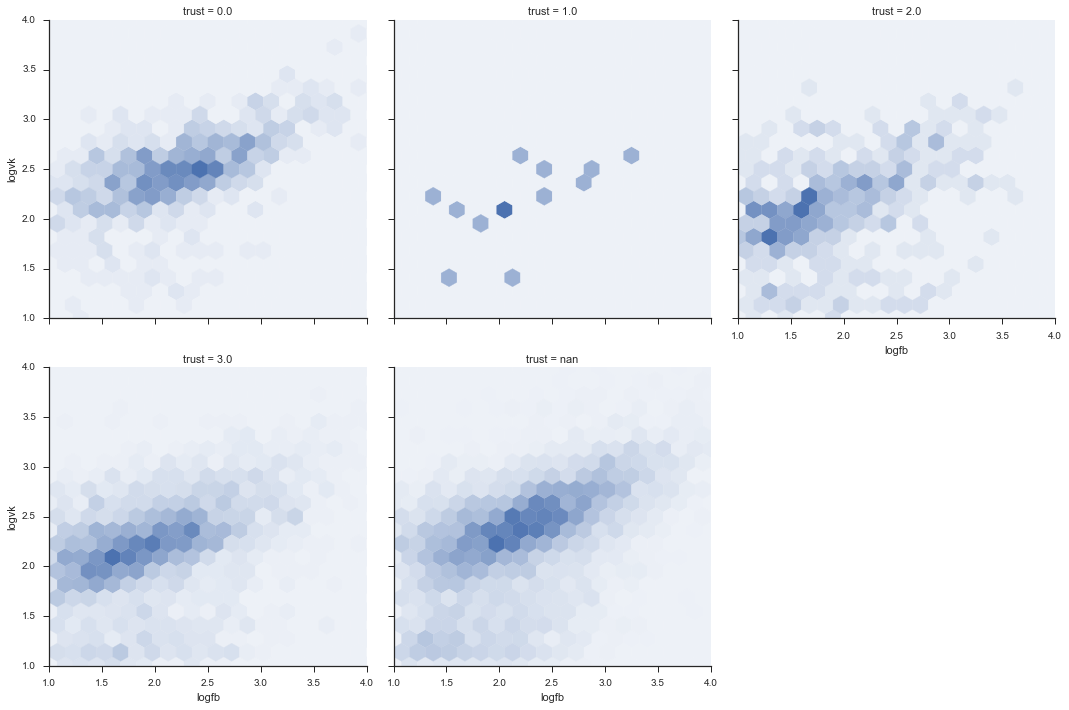

In [73]:
g = sns.FacetGrid(stripped.fillna('nan'), col="trust", margin_titles=True, size=5, col_wrap = 3)
g.map(hexbin, "logfb", "logvk", extent=[1, 4, 1, 4]);


In [81]:
stripped[stripped.trust == 2].head(2)

,affiliate,authors,bg_image,chapters_count,chat,document_type,document_urls,full,full_width,fun_type,...,version,vk_share_image,webview_url,with_banners,fb,tw,vk,trust,logvk,logfb
news/2015/07/31/kapitan-politsii-priznalsya-v-ogovore-glavy-kostromskogo-shtaba-demokraticheskoy-koalitsii,NaN,[],NaN,NaN,NaN,news,NaN,False,False,NaN,...,4,/image/share_images/13013_vk.png?1438352218,NaN,True,548,0,177,2.0,2.247973,2.738781
news/2015/08/01/mid-rf-prigrozil-arestovat-amerikanskoe-imuschestvo-v-rossii,NaN,[],NaN,NaN,NaN,news,NaN,False,False,NaN,...,4,/image/share_images/13025_vk.png?1438415604,NaN,True,148,0,139,2.0,2.143015,2.170262


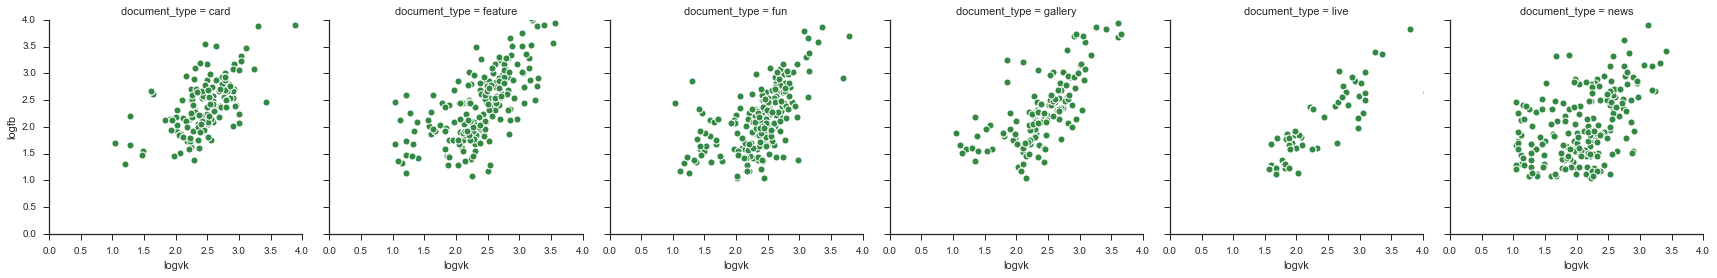

In [50]:
g = sns.FacetGrid(sample, col="document_type", margin_titles=True, size=4)
g.map(plt.scatter, "logvk", "logfb", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 4), ylim=(0, 4));


Теперь попробуем разобраться в данных глубже, и понять, есть ли у текстов аннотаций предсказательная сила для активности в соц.сетях.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
v = TfidfVectorizer(min_df=5)
X = v.fit_transform(stripped.title)
words = v.get_feature_names()
y = stripped.logfb

In [25]:
from sklearn.linear_model import Ridge
m = Ridge(alpha=1)
res = m.fit(X,y)

In [26]:
len(res.coef_)

2726

In [27]:
res.coef_.argmax()

2190

In [29]:
print X.shape
print len(words)

(10546, 2726)
2726


In [30]:
print words[res.coef_.argmax()]

серова


In [31]:
Ridge

sklearn.linear_model.ridge.Ridge

In [32]:
cv = sklearn.cross_validation.KFold(n=len(y), n_folds=5, random_state=42, shuffle=True, )
res = sklearn.cross_validation.cross_val_score(
    Ridge(alpha=.2),
    X = X, y = y, cv = cv, scoring = 'median_absolute_error'
)


In [ ]:
res

In [33]:
stripped.columns

Index([        u'affiliate',           u'authors',          u'bg_image',
          u'chapters_count',              u'chat',     u'document_type',
           u'document_urls',              u'full',        u'full_width',
                u'fun_type',       u'hide_header',             u'image',
                u'keywords',        u'layout_url',           u'live_on',
                  u'locale',       u'modified_at',       u'one_picture',
                   u'prefs',          u'pub_date',      u'published_at',
                  u'pushed',      u'second_title',     u'share_message',
                  u'social',            u'source',         u'sponsored',
          u'sponsored_card', u'table_of_contents',               u'tag',
                  u'thesis',             u'title',             u'topic',
              u'updated_at',               u'url',           u'version',
          u'vk_share_image',       u'webview_url',      u'with_banners',
                      u'fb',                u'tw', 

In [34]:
stripped.trust.unique()

array([ nan,   0.,   3.,   2.,   1.])

In [35]:
stripped[stripped.trust == 0 ].T

,feature/2015/01/27/poluchaesh-ot-nego-dokumenty-i-posylaesh-kuda-podalshe,feature/2015/06/02/v-mgu-ona-nadevala-hidzhab,feature/2015/06/29/trehlikiy-yanosh,feature/2015/08/02/anklav-esche-anklav,feature/2015/08/02/pishut-tolko-pro-nas-a-v-realnosti-takih-mnogo,feature/2015/08/05/bezvozmezdno-i-na-lyubye-tseli,feature/2015/08/05/marti-makflay-by-rasstroilsya,feature/2015/08/06/razvrat-i-moshennichestvo-v-shaoline,feature/2015/08/07/nam-tak-i-govorili-na-letuchkah-delayte-bolshe-ada,feature/2015/08/10/agrokompleks-aleksandra-tkacheva,...,shapito/2016/04/28/belorus-sel-na-shpagat-pered-mashinoy,shapito/2016/04/28/kapibara-v-yaponskom-zooparke-rodila-treh-malyshey,shapito/2016/04/28/schastlivaya-sobaka-prervala-futbolnyy-match-v-venesuele,shapito/2016/04/28/vyboine-na-doroge-v-missisipi-ustroili-den-rozhdeniya,shapito/2016/04/29/denis-matsuev-nashel-plot-yuriya-lozy-v-proizvedeniyah-motsarta-i-bethovena,shapito/2016/04/29/pochti-kak-zvezda-smerti,shapito/2016/04/29/tverskie-deputaty-poobeschali-chto-zhiteley-goroda-ne-budut-krutit-neizvestno-na-chem,shapito/2016/04/29/zhiteli-novosibirska-vyzvali-vooruzhennuyu-ohranu-iz-za-kota-rvavshegosya-v-kvartiru,shapito/2016/05/01/fleshmob-povsednevnye-predmety-prevraschayutsya-v-bomby-dlya-vanny,shapito/2016/05/04/pervomay-v-peterburge-vegany-podralis-s-lgbt-aktivistami
affiliate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
authors,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
bg_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chapters_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
document_type,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,...,fun,fun,fun,fun,fun,fun,fun,fun,fun,fun
document_urls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
full_width,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fun_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,video,picture,video,picture,video,picture,coub,picture,video,coub
